## Data Gathering

### Data info
The data we use is based on King County data which has geolocation. This data has been collected in 2014-2015
id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
- id - house ID
- date - sell date
- price - sell price
- bedrooms - no of bedrooms
- bathrooms - no of bathrooms(A bathroom without any shower or van is considered 0.5)
- sqft_living - usable interior space
- sqft_lot - the space of the land(Not sure so dropped, dataset didnt have any explinations on Kaggle)
- floors - no of floors
- waterfront - ?
- view - ?
- condition - house overall condition
- grade - ?
- sqft_above - ?
- sqft_basement - basement space
- yr_built,yr_renovated - years for construction and renovation
- zipcode,lat,long - geolocation

### Data mods
First of all we want to remodel the dataset:
- Drop unuseful columns from dataset
- Convert in eur currency/measure units



In [ ]:
import pandas as pd

def convert_sqft_to_sqm(value):
    return value * 0.092903

def convert_dollars_to_euros(value):
    return value * 0.92

df = pd.read_csv('../data/kc_house_data.csv')  

# Drop the columns that are not useful for the analysis: sqm_lot,waterfront,view,sqm_above,sqm_basement,zipcode

columns_to_drop = ['id','date','sqft_lot', 'waterfront', 'view', 'sqft_above', 'sqft_basement', 'zipcode']

df.drop(columns=columns_to_drop, inplace=True)

# Convert the columns from sqft to sqm and from dollars to euros
df['sqft_living'] = df['sqft_living'].apply(convert_sqft_to_sqm)
df['price'] = df['price'].apply(convert_dollars_to_euros)

new_column_names = {
    'sqft_living': 'sqm_living',
}
df.rename(columns=new_column_names, inplace=True)

df.to_csv('../data/prefinal_dataset.csv', index=False)

print("Conversion done! Check the 'prefinal_dataset.csv' file in the 'data' folder.")

#### Now we have to create and colect info about every graph to take the measurements on based on lat and long

In [35]:

import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt


def download_osm_data(location):
    """
    Download OpenStreetMap data for a specified location.
    """
    # Graph from OSM data
    G = ox.graph_from_place(location, network_type='walk')
    return G


def extract_poi_subgraph(G, poi_coords, radius=1250):
    """
    Extract a subgraph around a point of interest within a certain radius (in meters).
    """
    amenities = [
        'hospital', 'clinic', 'doctors', 'pharmacy', 'dentist',
        'school', 'college', 'kindergarten', 'university', 'library', 'music_school',
        'supermarket', 'marketplace', 'mall', 'bank', 'bureau_de_change',
        'restaurant', 'cafe', 'bar', 'pub', 'biergarten',
        'theatre', 'cinema', 'museum', 'arts_centre', 'gallery',
        'bus_station', 'ferry_terminal', 'taxi', 'car_rental', 'bicycle_rental', 'car_sharing',
        'park', 'stadium', 'swimming_pool', 'sports_centre'
    ]
    # Get the nearest node to the POI
    nearest_node = ox.distance.nearest_nodes(G, poi_coords[1], poi_coords[0])
    
    # fetch amenities
    try:
        poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)
        
    except Exception as e:
        print(e)
        return None, None, None
    
    # Generate a subgraph around the nearest node within the specified radius
    subgraph = nx.ego_graph(G, nearest_node, radius=radius, distance='length')
    
    return subgraph, poi_df, nearest_node


def plot_graph(G):
    """
    Plot the graph.
    """
    fig, ax = ox.plot_graph(G, show=False, close=False)
    plt.show()

In [25]:
location = 'King County, Washington, USA'
# download OSM data
G = download_osm_data(location)

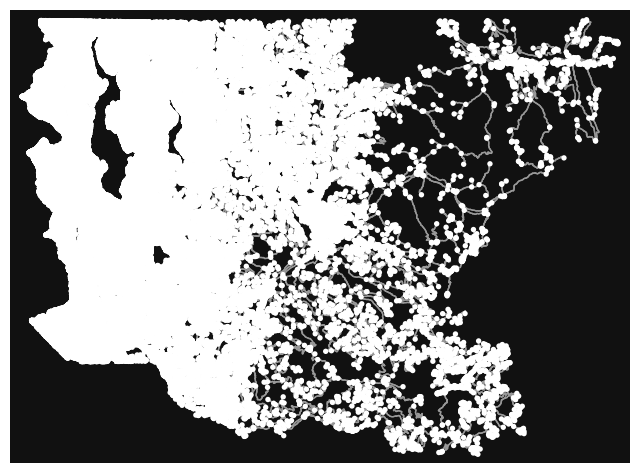

In [37]:
plot_graph(G)

In [39]:
# extract subgraph around the point of interest
subG, pointsOfInterest, nearestNode = extract_poi_subgraph(G, poi_coords)

C:\Users\geote\AppData\Local\Temp\ipykernel_31756\4076079392.py:37: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  poi_df = ox.geometries_from_point(poi_coords, tags={'amenity': amenities}, dist=radius)


In [ ]:
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import sklearn

import sys
import os

utils_path = os.path.join(os.getcwd(), '..', 'utils')  # Assumes utils is one directory up from the script
sys.path.append(utils_path)
# Import utils file
from utils import clustering_coef

# Test if the function can be accessed
print("Access to function:", clustering_coef)

# Set up configuration for osmnx
ox.config(use_cache=True, log_console=True)

# Function to fetch points of interest and graph
def fetch_pois(lat, lon, dist=1250, network_type='walk', plot=True):
    point = (lat, lon)
    try:
        G = ox.graph_from_point(point, dist=dist, network_type=network_type, simplify=True)
        amenities = [
            'hospital', 'clinic', 'doctors', 'pharmacy', 'dentist',
            'school', 'college', 'kindergarten', 'university', 'library', 'music_school',
            'supermarket', 'marketplace', 'mall', 'bank', 'bureau_de_change',
            'restaurant', 'cafe', 'bar', 'pub', 'biergarten',
            'theatre', 'cinema', 'museum', 'arts_centre', 'gallery',
            'bus_station', 'ferry_terminal', 'taxi', 'car_rental', 'bicycle_rental', 'car_sharing',
            'park', 'stadium', 'swimming_pool', 'sports_centre'
        ]
        pois = ox.geometries_from_point(point, tags={'amenity': amenities}, dist=dist)
        nearest_node = ox.distance.nearest_nodes(G, lon, lat)

    except Exception as e:
        print(f"Error fetching POIs for location ({lat}, {lon}): {e}")
        return None, None, None

    if plot and G is not None:
        fig, ax = ox.plot_graph(G, show=False, close=False)
        pois['geometry'].plot(ax=ax, color='red', markersize=30)
        x, y = G.nodes[nearest_node]['x'], G.nodes[nearest_node]['y']
        ax.scatter(x, y, color='blue', s=100, zorder=5)
        plt.show()
        return G, pois, nearest_node
    return G, pois, nearest_node

# Load your data
df = pd.read_csv('../data/prefinal_dataset.csv')

# Fetch POIs for the first location
lat, lon = df['lat'][0], df['long'][0]
graph, points_of_interest, nearest_node = fetch_pois(lat, lon)
print(points_of_interest.head())  # Display some of the POIs
print("Nearest node:", nearest_node)

# Perform your analysis here
# Average node degree
print("Average node degree:", sum(dict(graph.degree()).values()) / len(graph.nodes))

#measure degree centrality
degree_centrality = nx.degree_centrality(graph)
print("Degree centrality:", degree_centrality[nearest_node])

# Measure betweenness centrality
betweenness_centrality = nx.betweenness_centrality(graph)
print("Betweenness centrality:", betweenness_centrality[nearest_node])

# Measure closeness centrality
closeness_centrality = nx.closeness_centrality(graph)
print("Closeness centrality:", closeness_centrality[nearest_node])

# Measure graph density and average path length
density = nx.density(graph)
print("Graph density:", density)

#### Doing the example for all samples

!!! DONT START A FULL RUN ON THIS YET

In [ ]:
# Load data
df = pd.read_csv('../data/final_dataset.csv')

max_iterations = 10
start_index = 50

for index, row in df.iterrows():
    if index < start_index:
        continue
    if index >= start_index + max_iterations:
        print("Max iterations reached.")
        break

    lat = row['lat']
    lon = row['long']

    subGraph, pointOfInterest, nearestNode = extract_poi_subgraph(
        G, (lat, lon))

    if subGraph is None or pointOfInterest is None or nearestNode is None:
        print(f"Error processing index {index}, skip.")
        continue

    avg_degree = sum(dict(subGraph.degree()).values()) / len(subGraph.nodes)
    degree_centrality = nx.degree_centrality(subGraph)
    betweenness_centrality = nx.betweenness_centrality(subGraph)
    closeness_centrality = nx.closeness_centrality(subGraph)
    density = nx.density(subGraph)

    df.at[index, 'avg_degree'] = avg_degree
    df.at[index, 'degree_centrality'] = degree_centrality[nearestNode]
    df.at[index, 'betweenness_centrality'] = betweenness_centrality[nearestNode]
    df.at[index, 'closeness_centrality'] = closeness_centrality[nearestNode]
    df.at[index, 'density'] = density
    print("Done for index:", index)

    # save the updated dataframe
    df.to_csv('../data/final_dataset.csv', index=False)